Doing some science-working through JL's list and my own ideas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
model = Table.read('saved_models/trappist-1_model_var_res_v07.ecsv')
mw, mf = model['WAVELENGTH'], model['FLUX']

In [3]:
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
w_sol, f_sol = w_sol[w_sol >= mw[0]], f_sol[w_sol >= mw[0]]
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = ((u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2).value

###scale by 1 au flux
#au_scale = ((u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2).value


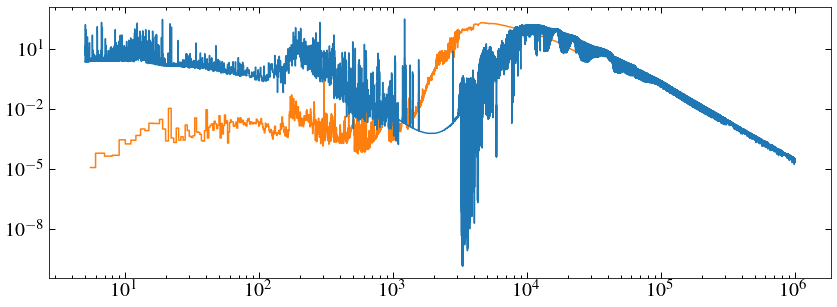

In [4]:
plt.step(mw, mf*bb_scale, where='mid')
plt.step(w_sol, f_sol, zorder=-1,where='mid')
plt.xscale('log')
plt.yscale('log')



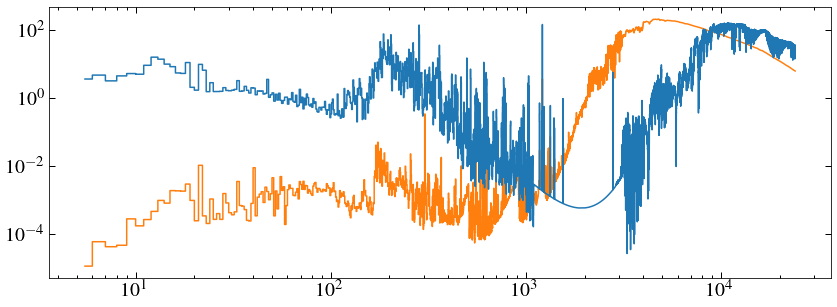

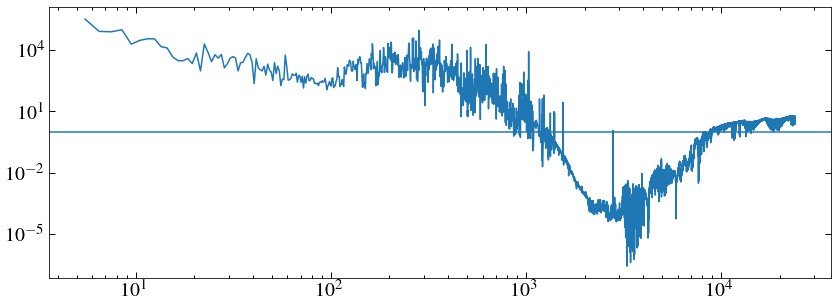

In [5]:
t1sw, t1sf = resample.bintogrid(mw, mf, newx=w_sol)
plt.step(t1sw, t1sf*bb_scale, where='mid')
plt.step(w_sol, f_sol, zorder=-1,where='mid')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.plot(w_sol, t1sf*bb_scale/f_sol)
plt.xscale('log')
plt.yscale('log')
plt.axhline(1)


In [6]:
xuv_cut = 2000 #Angstroms this doesn't work, have to remove the blackbody
#t1_flux = np.trapz(mf, mw)
#t1_bb_flux = (const.sigma_sb *(4*np.pi*r_t1.to(u.cm)**2) * t_t1 ** 4 ).to(u.erg/u.s)/(4*np.pi*(d_t1.to(u.cm))**2)
#print(t1_flux, t1_bb_flux)

In [7]:
xuv_earth = np.trapz(f_sol[w_sol <=xuv_cut], w_sol[w_sol <=xuv_cut])
xuv_t1 = np.trapz(mf[mw <=xuv_cut], mw[mw <=xuv_cut])
print(xuv_earth)
print(xuv_earth/bb_scale)
print(xuv_t1)

99.868866
8.46313416961344e-15
2.1353720172569118e-13


Habitable zone calculations from https://iopscience.iop.org/article/10.1088/2041-8205/787/2/L29

In [8]:
S_effsuns = [1.776,1.107,0.356,0.32]

a_all = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5]
b_all = [2.533e-8, 1.58e-8, 1.698e-9, 1.526e-9]
c_all = [-1.332e-11, -8.308e-12,-3.198e-12,-2.874e-12]
d_all = [-3.097e-15,-1.931e-15,-5.575e-16,-5.011e-16]

t_star = t_t1.value - 5780 

l_t1 = 10**-3.28 #lsun

hzs = []
for s, a, b, c, d in zip(S_effsuns, a_all, b_all, c_all,d_all):
    Seff = s + a*t_star + b*t_star**2 + c*t_star**3 +d*t_star**4
    d_hz = (l_t1/Seff)**0.5
    hzs.append(d_hz)
print (hzs)
    

[0.018942461658199808, 0.023992418349443854, 0.04864997693231791, 0.05131643030421871]


In [9]:
#t1 planet semi-major axies
#t1_a = np.array([0.01111, 0.01521, 0.02144, 0.02817,0.0371,0.0451,0.063])
#t1_a_error_up = np.array([0.00034,0.00047, 0.00066,0.00083,0.0011,0.0014,0.027])
#t1_a_error_down = np.array([0.00034,0.00047, 0.00063, 0.00087,0.0011,0.0014,0.013])

#new ones from ducrot et al 2020
#11.534+0.099−0.09215.79+0.14−0.1322.26+0.19−0.1829.24+0.25−0.2338.7740+0.33−0.3146.81528+0.40−0.3761.8656+0.53−0.49
t1_a = np.array([11.534, 15.79, 22.26, 29.24, 38.7740, 46.81528, 61.8656])*1e-3
t1_a_error_up = np.array([0.099, 0.14, 0.19, 0.25, 0.33, 0.40, 0.53])*1e-3
t1_a_error_down = np.array([0.092, 0.13, 0.18, 0.23, 0.31, 0.37, 0.49])*1e-13
teqs = [397.6, 339.7, 286.2, 249.7, 217.7, 197.3, 171.7]
names  = ['b', 'c', 'd', 'e', 'f','g', 'h']

In [10]:
#testing teq calcuations

def make_teq(a):
    a = (a*u.au).to(u.m)
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    teq = ( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi*a**2) )**(1/4)
    return teq



for a in t1_a:
    print(make_teq(a))
#yes!

397.4213438424208 K
339.6644507892247 K
286.0741268596016 K
249.60453803100563 K
216.75586530522367 K
197.26377890220812 K
171.59970876979878 K


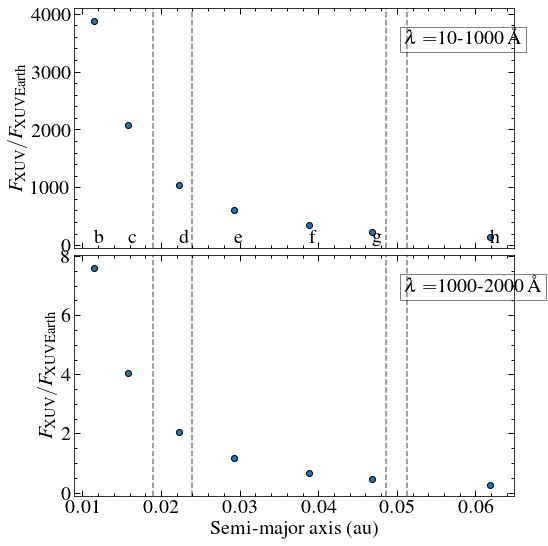

In [11]:
xuv_cuts = [10, 1000, 2000]
plt.figure(figsize=(8,8))

d_t1_au = d_t1.to(u.au).value
for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    plt.errorbar(t1_a, np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], yerr=[np.array(xuv_el), np.array(xuv_eu)], ls='none', marker='o',  mec='k')
    plt.ylabel('$F_{\mathrm{XUV}}/F_{\mathrm{XUV Earth}}$')
    if i ==0:
        [plt.annotate(name, (p, 45)) for name, p in zip(names, t1_a)]
       # plt.ylim(-0.9, 49)
        plt.xticks(visible=False)
    plt.annotate(r'$\lambda = ${0}\--{1}\,\AA'.format(cut, cutu), (0.75, 0.85), xycoords='axes fraction', bbox=dict(facecolor='none', edgecolor='k', alpha=0.5))
    [plt.axvline(hz, c='k', ls='--', alpha = 0.5) for hz in hzs]
   # plt.ylim(-0.9, 49)
plt.xlabel('Semi-major axis (au)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.03)
#plt.savefig('t1_planets_xuv.pdf', dpi=150)
#plt.savefig('t1_planets_xuv.png', dpi=150)

[0.011534   0.01579    0.02226    0.02924    0.038774   0.04681528
 0.0618656 ]
[397.4213438424208, 339.6644507892247, 286.0741268596016, 249.60453803100563, 216.75586530522367, 197.26377890220812, 171.59970876979878]
0 1000
[3913.042665157092, 2087.902514472124, 1050.567973747525, 608.863220870932, 346.2527771580507, 237.51947622077267, 136.01162168678349]
1000 2000
[7.589048024989451, 4.049327801844723, 2.0374965183176075, 1.1808438136857782, 0.6715308723915806, 0.46065092209706826, 0.2637841744299658]
2000 3000
[0.002230977031314154, 0.0011903940110050844, 0.0005989694516072664, 0.0003471364810484307, 0.00019741210586502446, 0.00013541904376783456, 7.754548824036965e-05]
[0.01487121 0.02024137 0.02914757 0.04554307 0.05948483]


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning: AutoMinorLocator does not work with logarithmic scale


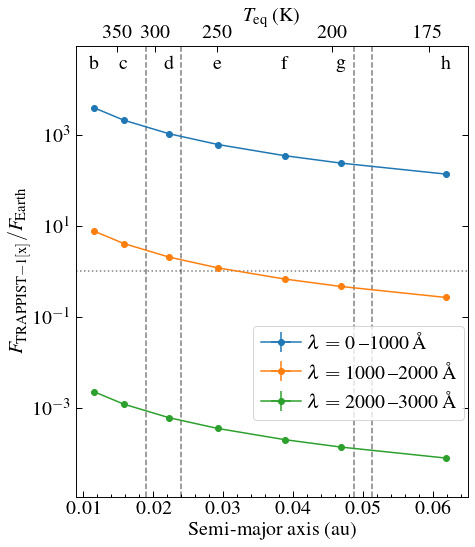

In [83]:
xuv_cuts = [0, 1000, 2000, 3000]
fig, ax = plt.subplots(figsize=(7,8))


#plt.set_cmap(winter)
rcParams['image.cmap']='viridis'

def make_teq(a):
    a = (a*u.au).to(u.m)
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    teq = ( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi*a**2) )**(1/4)
    return teq

def make_a(teff):
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    coeff = (( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi))**(1/4))
    a = (coeff/(teff*u.K))**2
    return a.to(u.au)
    
#make_a(300)
    
lt1 = (0.000553*u.Lsun).to(u.W)
Ab = 0
coeff = (( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi))**(1/4))

#def t_to_s(x):
 #  # print(x)
  #  tx = [make_teq(a).value for a in x]
    #print(tx)
   # return np.array(tx)

def t_to_s(x):
    a = (x*u.au).to(u.m)
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    teq = ( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi*a**2) )**(1/4)
    return teq.value

#def t_to_s(x):
 #   return (coeff*(((x*u.au).to(u.m))**(-1/2))).value
    
d_t1_au = d_t1.to(u.au).value
print(t1_a)

print([make_teq(a).value for a in t1_a])

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off   


for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    #plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    print(cut, cutu)
    print(planet_xuv)
    plt.errorbar(np.array(t1_a), np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], 
                yerr=[np.array(xuv_el), np.array(xuv_eu)], marker='o', label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu))
ax.plot([0, 1000], [1e-10,1e-10])
#secax = ax.secondary_xaxis('top', functions =(t_to_s, t_to_s))
#secax.set_xlabel(r'$T_{\mathrm{eq}}$ (K)', size =25)
ax.set_ylabel('$F_{\mathrm{TRAPPIST-1 [x]}}/F_{\mathrm{Earth}}$')
    #if i ==0:
[plt.annotate(name, (p, 0.95), xycoords=('data', 'axes fraction'), ha='center') for name, p in zip(names, t1_a)]

[plt.axvline(hz, c='k', ls='--', alpha = 0.5) for hz in hzs]
plt.legend(loc=(0.45, 0.17), frameon=True)
   # plt.ylim(-0.9, 49)
ax.set_xlabel('Semi-major axis (au)')
#plt.subplots_adjust(hspace=0.03)
ax.set_yscale('log')
ax.set_ylim(1.1e-5, 9e4)
ax.set_xlim(0.009, 0.065)
#plt.xlim(0.01, 0.12)
plt.axhline(1, ls=':',alpha = 0.5, c='k')
#secax.set_xticks((200, 400), ('400', '200'))


teffs = np.array([350, 300, 250, 200, 175])
tas = np.array([make_a(t).value for t in teffs])

teqs = np.array([make_teq(a).value for a in t1_a])

print(tas)

ax2 = ax.twiny()
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off   

#ax2.plot(np.array(t1_a), np.array(planet_xuv))

teqp = np.array([str(t) for t in teffs])
#plt.xticks(tas, teqp, minor=False)
#ax2.set_xlim(500, 50)
ax2.set_xticks(tas, minor=False)
ax2.set_xticklabels(teqp)

ax2.set_xlim(0.009, 0.065)
ax2.set_xlabel(r'$T_{\mathrm{eq}}$ (K)', size=20)

#plt.xticks(tas, str(teffs), which='top')

#fig.axes[0].invert_xaxis(secondary=True)
#secax.invert_xaxis() 
#can I add instellation to this plot 20201027
#teqs = [397.6, 339.7, 286.2, 249.7, 217.7, 197.3, 171.7]





plt.tight_layout()
#plt.subplots_adjust(top=0.7)

plt.savefig('../plots/t1_planets_xuv_teq.pdf', dpi=150)
plt.savefig('../plots/t1_planets_xuv_teq.png', dpi=150)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


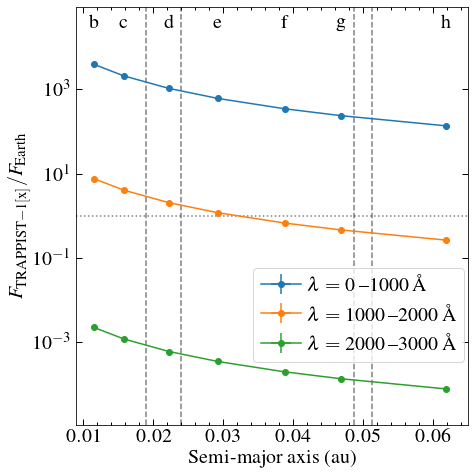

In [14]:
xuv_cuts = [0, 1000, 2000, 3000]
plt.figure(figsize=(7,7))

#plt.set_cmap(cm.cool)

rcParams['image.cmap']='cool'

d_t1_au = d_t1.to(u.au).value


for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    #plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    plt.errorbar(np.array(t1_a), np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], 
                yerr=[np.array(xuv_el), np.array(xuv_eu)], marker='o', label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu) )
plt.ylabel('$F_{\mathrm{TRAPPIST-1 [x]}}/F_{\mathrm{Earth}}$')
    #if i ==0:
[plt.annotate(name, (p, 0.95), xycoords=('data', 'axes fraction'), ha='center') for name, p in zip(names, t1_a)]

[plt.axvline(hz, c='k', ls='--', alpha = 0.5) for hz in hzs]
plt.legend(loc=(0.45, 0.15), frameon=True)
   # plt.ylim(-0.9, 49)
plt.xlabel('Semi-major axis (au)')
#plt.subplots_adjust(hspace=0.03)
plt.yscale('log')
plt.ylim(1.1e-5, 9e4)
plt.xlim(0.009, 0.065)
#plt.xlim(0.01, 0.12)
plt.axhline(1, ls=':',alpha = 0.5, c='k')



#cmap=plt.cm.plasma

plt.tight_layout()

#plt.savefig('../plots/t1_planets_xuv.pdf', dpi=150)
#plt.savefig('../plots/t1_planets_xuv.png', dpi=150)

In [ ]:
"""#cyberpunk one because I can
import mplcyberpunk

plt.style.use("cyberpunk")

xuv_cuts = [0, 1000, 2000, 3000]
plt.figure(figsize=(7,7))

plt.set_cmap(cm.cool)

rcParams['image.cmap']='cool'

d_t1_au = d_t1.to(u.au).value


for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    #plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    plt.errorbar(np.array(t1_a), np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], 
                yerr=[np.array(xuv_el), np.array(xuv_eu)], marker='o', label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu) )
plt.ylabel('$F_{\mathrm{TRAPPIST-1 [x]}}/F_{\mathrm{Earth}}$')
    #if i ==0:
[plt.annotate(name, (p, 0.95), xycoords=('data', 'axes fraction'), ha='center') for name, p in zip(names, t1_a)]

[plt.axvline(hz, c='C3', ls='--', alpha = 0.5) for hz in hzs]
plt.legend(loc=(0.45, 0.15), frameon=True)
   # plt.ylim(-0.9, 49)
plt.xlabel('Semi-major axis (au)')
#plt.subplots_adjust(hspace=0.03)
plt.yscale('log')
plt.ylim(1.1e-5, 9e4)
plt.xlim(0.009, 0.065)
#plt.xlim(0.01, 0.12)
plt.axhline(1, ls=':',alpha = 1, c='C4')

#mplcyberpunk.add_glow_effects()
mplcyberpunk.make_lines_glow()
#plt.fill_between([0, hzs[0]], 10000, fc='r', alp)
plt.tight_layout()

#plt.savefig('../plots/t1_planets_xuv.pdf', dpi=150)
plt.savefig('../plots/t1_planets_xuv_cp.png', dpi=150)

#plt.style.use("default")"""

Semi-emp v Phoenix

In [ ]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
d = 12.14*u.pc
r = 0.117*const.R_sun
scale = (r/d.to(u.m))**2
mods = os.listdir(mpath)
mods

In [ ]:
mods = ['TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

In [ ]:
pw, pf = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
pw1, pf1 = resample.bintogrid(pw, pf, dx=1.)
pmask = (pw1 > 4000) & (pw1 <= mw[-1])
mmask = mw > 4000
scale_to_muscles = (np.trapz(mf[mmask], mw[mmask])/np.trapz(pf1[pmask], pw1[pmask]))

In [ ]:
plt.figure(figsize=(8,5))
plt.step(mw,mf, where='mid', label='Mega-MUSCLES')
#for mod in mods[0:1]:
 #   pw, pf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    #pf1 = interp1d(pw, pf*scale, fill_value='extra')
  #  pw1, pf1 = resample.bintogrid(pw, pf*scale, dx=1.)
plt.step(pw1[pf1>0], pf1[pf1>0]*scale_to_muscles, where='mid', zorder=-1, label = 'Peacock et al. 2019 Model 1A')

#plt.step(lw, lf, where='mid', label='EUV Estimate')
plt.xlim(50, 5000)
plt.ylim(1e-25, 1e-13)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.savefig('T1_mm_v_phoenix.pdf', dpi=150)

In [ ]:
bins = np.arange(0, 4000, 100)
bins

In [ ]:
binsize=100
bins = np.arange(200, 4000, binsize)
ratio1 = []
ratio2 = []
ratio3 = []
for i in range(len(bins)):
    mmask = (mw > bins[i]) & (mw < bins[i]+binsize)
    pmask = (pw1> bins[i]) & (pw1 < bins[i]+binsize)
    mflux = np.trapz(mf[mmask], mw[mmask])
    pflux = np.trapz(pf1[pmask]*scale_to_muscles, pw1[pmask])
    ratio1.append(pflux/mflux)
plt.ylabel('$F_{\mathrm{mod}}/F_{\mathrm{obs}}$', size=20)
plt.step(bins+binsize/2, ratio1, where='mid')
plt.yscale('log')

20200810 Doing the  Swift comparision with the semi-emprical model

In [ ]:
sf = 8e-15 #erg/cm2/s
sfe = 1.4e-15
scenw = 1928 
swb = 657

In [ ]:
bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.UVW2.dat', unpack=True)

In [ ]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)


uvm2phot = make_phot(bpw, bpf, mw, mf)
print(uvm2phot*(bpw[-1]-bpw[0]))

In [ ]:
plt.plot(bpw, bpf)
plt.axvline(2795)
plt.axvline(2802)
#plt.xlim(2790, 2810)
#plt.ylim(0, 5)

In [ ]:
2.5/max(bpf)